In [6]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
"""

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank_iter, eprank_non_iter
from tqdm import tqdm
import pandas as pd
from scipy.stats import norm
from cw2 import sorted_barplot
import scipy

import seaborn as sns

sns.set(rc={"figure.figsize": (14, 8.27)})

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [7]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [8]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)


  0%|          | 3/1100 [00:00<00:48, 22.84it/s]

100%|██████████| 1100/1100 [00:42<00:00, 25.95it/s]


Plot selected players

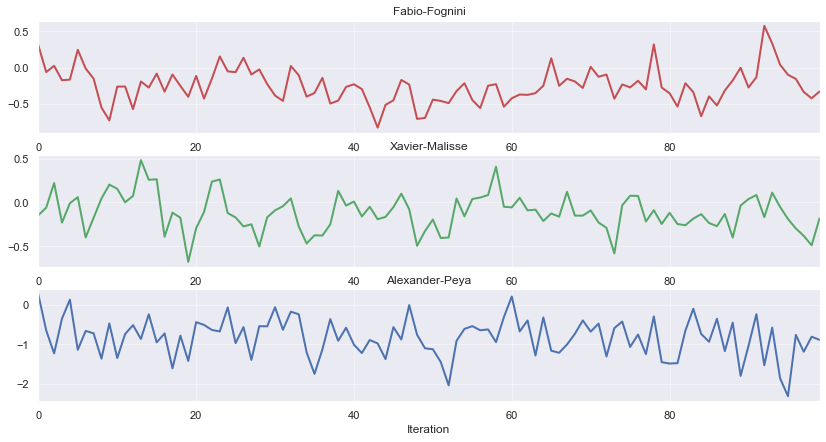

In [9]:
no_to_show = 3
fig, axes = plt.subplots(no_to_show, 1, figsize=(14, 7))

players_to_show = np.random.choice(M, size=no_to_show, replace=False)
steps_to_show = 100
colors = "rgb"
for i in range(no_to_show):
    axes[i].plot(
        np.arange(steps_to_show),
        skill_samples[players_to_show[i], :steps_to_show].T,
        label=W[i, 0],
        linewidth=2.0,
        color=colors[i],
    )
    axes[i].set_xlim(0, steps_to_show - 1)
    axes[i].set_title(W[players_to_show[i], 0])
    axes[i].grid(alpha=0.4)
plt.xlabel("Iteration")
plt.savefig("plots/Ta_sample_skills.png", format="png", dpi=500, bbox_inches="tight")

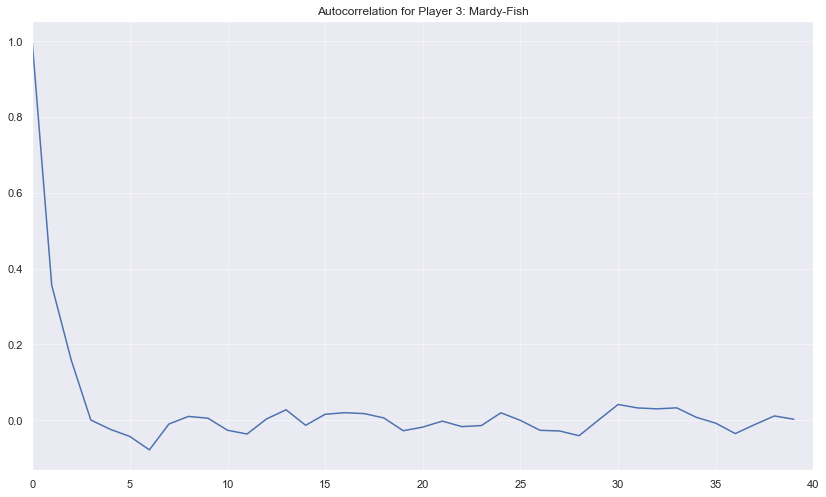

In [11]:
# Code for plotting the autocorrelation function for player p
p = 3
steps = 40
autocor = np.zeros(steps)
for i in range(steps):
    autocor[i] = pd.Series.autocorr(pd.Series(skill_samples[p, :]), lag=i)
plt.plot(autocor)
plt.xlim(0,steps)
plt.title(f"Autocorrelation for Player {p}: {W[p,0]}")
plt.grid(alpha = 0.4)
plt.savefig('plots/Ta_acorr.png', format="png", dpi=500, bbox_inches="tight")

# EP ranking

In [12]:
num_iters = 400
# from eprank import eprank, eprank_iter
# run message passing algorithm, returns mean and precision for each player
# mean, precision = eprank_non_iter(G, M, num_iters) # final skills after iteration
# print(len(mean_player_skills)) 


In [46]:
mean_skills = np.zeros((num_iters, M))
precision_skills = np.zeros((num_iters, M))
for i, (mean, precision) in tqdm(enumerate(eprank_iter(G, M, num_iters))):
    mean_skills[i] = mean
    precision_skills[i] = precision
std_dev = np.true_divide(1, precision_player_skills)

mean_player_skills = mean_skills[-1]
precision_player_skills = precision_skills[-1]
# print((mean_skills[1:] - mean_skills[:-1])[:50].shape)

5it [00:00, 81.89it/s]


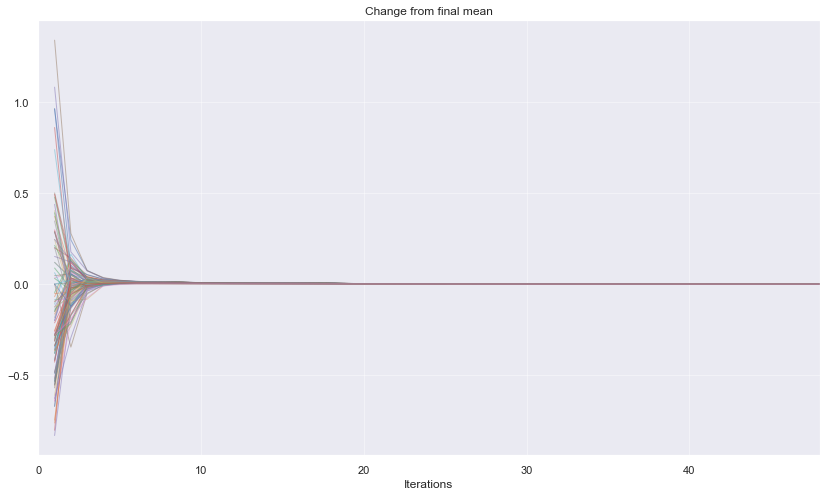

In [14]:
show_n_iter = 49
plt.figure(figsize=(14, 8))
plt.plot(
    np.arange(1, show_n_iter + 1),
    (mean_skills[1:] - mean_skills[:-1])[:show_n_iter],
    alpha=0.5,
    linewidth=1.0,
)
plt.xlim(0, show_n_iter - 1)
plt.title("Change from final mean")
plt.xlabel("Iterations")
plt.ylabel("")
plt.grid(alpha = 0.4)
plt.savefig('plots/change_in_mean_normal.png', format='png', dpi=500, bbox_inches='tight')

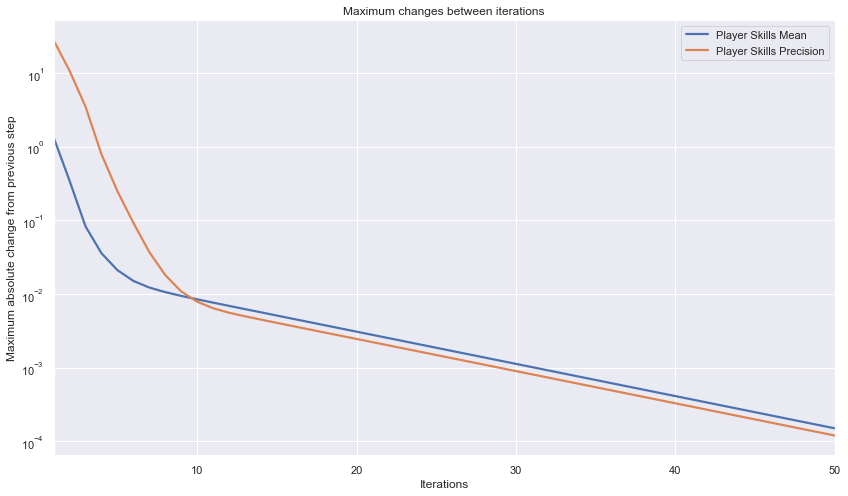

In [15]:
# Maximum change in mean and precision
show_n_iter = 50
plt.figure(figsize=(14, 8))

max_mean_change = np.max(np.abs(mean_skills[1:] - mean_skills[:-1]), axis=1)
max_prec_change = np.max(np.abs(precision_skills[1:] - precision_skills[:-1]), axis=1)

plt.plot(
    np.arange(1, show_n_iter + 1),
    max_mean_change[:show_n_iter],
    label="Player Skills Mean",
    linewidth=2.2,
)
plt.plot(
    np.arange(1, show_n_iter + 1),
    max_prec_change[:show_n_iter],
    label="Player Skills Precision",
    linewidth=2.2,
)
plt.yscale("log")
plt.xlim(1, show_n_iter)
plt.xlabel("Iterations")
plt.ylabel("Maximum absolute change from previous step")
plt.legend()
plt.title("Maximum changes between iterations")
plt.savefig('plots/max_change_in_mean_and_precision.png', format='png', dpi=500, bbox_inches='tight')

In [16]:
# Get top 4 players (by ATP) player IDs
top_4_atp = ["Novak-Djokovic", "Rafael-Nadal", "Roger-Federer", "Andy-Murray"]
top_4_atp_ids = []
for name in top_4_atp:
    top_4_atp_ids.append(int(np.argwhere(W[:, 0] == name)))
print(top_4_atp_ids)
top_4_atp_ids = np.array(top_4_atp_ids)

djok_nadal = ["Novak-Djokovic", "Rafael-Nadal"]
djok_nadal_ids = []
for name in djok_nadal:
    djok_nadal_ids.append(int(np.argwhere(W[:, 0] == name)))
print(djok_nadal_ids)
djok_nadal_ids = np.array(djok_nadal_ids)

[15, 0, 4, 10]
[15, 0]


In [17]:
top_4_means = mean_player_skills[top_4_atp_ids]
top_4_vars = precision_player_skills[top_4_atp_ids] ** (-1)

djok_nadal_means = mean_player_skills[top_4_atp_ids]
djok_nadal_vars = precision_player_skills[top_4_atp_ids] ** (-1)

In [18]:
mean_differences = top_4_means[:, None] - top_4_means[None, :]
vars_sums = top_4_vars[:, None] + top_4_vars[None, :]

In [19]:
prob_has_better_skill = 1.0 - norm.cdf(
    0, mean_differences, vars_sums**0.5
)
print(prob_has_better_skill)

[[0.5        0.93982214 0.90888525 0.9853215 ]
 [0.06017786 0.5        0.42717033 0.76651864]
 [0.09111475 0.57282967 0.5        0.81083534]
 [0.0146785  0.23348136 0.18916466 0.5       ]]


In [20]:
prob_win = 1.0 - norm.cdf(0, mean_differences, (vars_sums + 1.0) ** 0.5)
print(prob_win)

[[0.5        0.65536701 0.63802696 0.71982573]
 [0.34463299 0.5        0.48164814 0.57311   ]
 [0.36197304 0.51835186 0.5        0.59087907]
 [0.28017427 0.42689    0.40912093 0.5       ]]


# TASK D

In [21]:
skill_samples_burned_in = skill_samples[:, 100:]
print(skill_samples_burned_in.shape)

(107, 1000)


In [22]:
skill_samples_burned_in = skill_samples[:, 100:]
print(skill_samples_burned_in.shape)

(107, 1000)


In [23]:
skill_samples_df = pd.DataFrame(
    {W[i, 0]: skill_samples_burned_in[i] for i in range(W.shape[0])}
)

Text(25.0, 0.5, 'Nadal Skill')

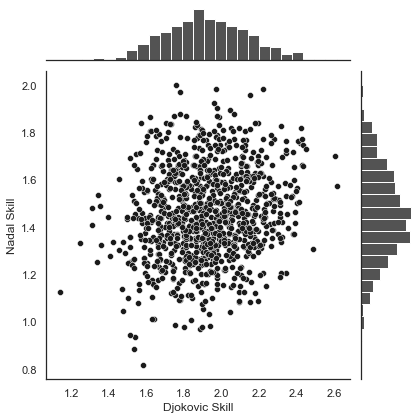

In [24]:
with sns.axes_style("white"):
    sns.jointplot(
        x="Novak-Djokovic", y="Rafael-Nadal", data=skill_samples_df, color="k"
    )
plt.xlabel("Djokovic Skill")
plt.ylabel("Nadal Skill")
# plt.savefig('plots/djokovic-vs-nadal-gibbs-samples.eps', format='eps', dpi=200, bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/axisgrid.py:1615: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)


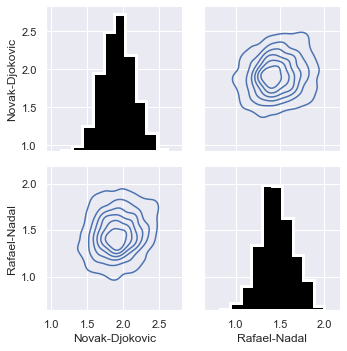

In [25]:
with sns.axes_style("darkgrid"):
    g = sns.PairGrid(skill_samples_df[djok_nadal], palette="pastel")
    g.map_diag(plt.hist, linewidth=3, histtype="stepfilled", color="black")
    g.map_offdiag(sns.kdeplot, n_levels=7)
#     g.map_offdiag(plt.scatter, marker='+', alpha=0.5, color=sns.color_palette('pastel', 2)[0]);
# plt.savefig(
#     "plots/pair-grid-top4-atp-gibbs-samples.eps",
#     format="eps",
#     dpi=200,
#     bbox_inches="tight",
# )

#### Calculate marginal Gaussians

In [26]:
marginal_skill_means = np.mean(skill_samples_burned_in[[15, 0], :], axis=1)
marginal_skill_vars = np.var(skill_samples_burned_in[[15, 0], :], axis=1)
print(marginal_skill_means, marginal_skill_vars)

[1.91613241 1.45733666] [0.04837935 0.03585946]


In [27]:
# Probability Djokovic's skill is higher
prob_skill_higher = 1.0 - norm.cdf(
    0,
    marginal_skill_means[0] - marginal_skill_means[1],
    (marginal_skill_vars.sum()) ** 0.5,
)
print(prob_skill_higher)

0.943032434266366


#### Calcualate Joint Gaussians

In [28]:
mean = np.mean(skill_samples_burned_in[[15, 0], :], axis=1)
cov = np.cov(skill_samples_burned_in[[15, 0], :], rowvar=1)
print(cov)

[[0.04842778 0.00690428]
 [0.00690428 0.03589535]]


In [29]:
mc_joint_gaussian_samples = np.random.multivariate_normal(mean, cov, size=100000)
prob_skill_higher = np.mean(
    mc_joint_gaussian_samples[:, 0] > mc_joint_gaussian_samples[:, 1]
)
print(prob_skill_higher)

0.95745


#### Calculate directly from Gibbs samples (Djokovic vs Nadal)

In [30]:
prob_skill_higher = np.mean(
    skill_samples_burned_in[15, :] > skill_samples_burned_in[0, :]
)
print(prob_skill_higher)

0.957


#### Calculate from Gibbs for 4 top players

In [31]:
prob_higher_skill = np.zeros([4, 4])
for i in range(4):
    for j in range(4):
        player1 = top_4_atp_ids[i]
        player2 = top_4_atp_ids[j]
        prob_higher_skill[i, j] = np.mean(
            skill_samples_burned_in[player1, :] > skill_samples_burned_in[player2, :]
        )
print(np.array(prob_higher_skill))

[[0.    0.957 0.934 0.989]
 [0.043 0.    0.381 0.74 ]
 [0.066 0.619 0.    0.808]
 [0.011 0.26  0.192 0.   ]]


## Player rankings

In [32]:
skill_mean_gibbs = np.mean(skill_samples_burned_in, axis=1)
skill_std_gibbs = np.std(skill_samples_burned_in, axis=1)
skill_mean_mp = mean_player_skills
skill_std_mp = (1 / precision_player_skills) ** 0.5

In [33]:
def sorted_rangeplot(mean, std_dev, W, label_x="", title_x=""):
    label = str(label_x)
    print(type(label_x))
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    sorted_indices = np.argsort(mean)
    sorted_names = W[sorted_indices]
    plt.barh(xx, std_dev[sorted_indices], left=mean[sorted_indices])
    plt.yticks(np.linspace(0, M, M), labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.xlabel(label)
    plt.title(title_x)
    plt.show()

<class 'str'>


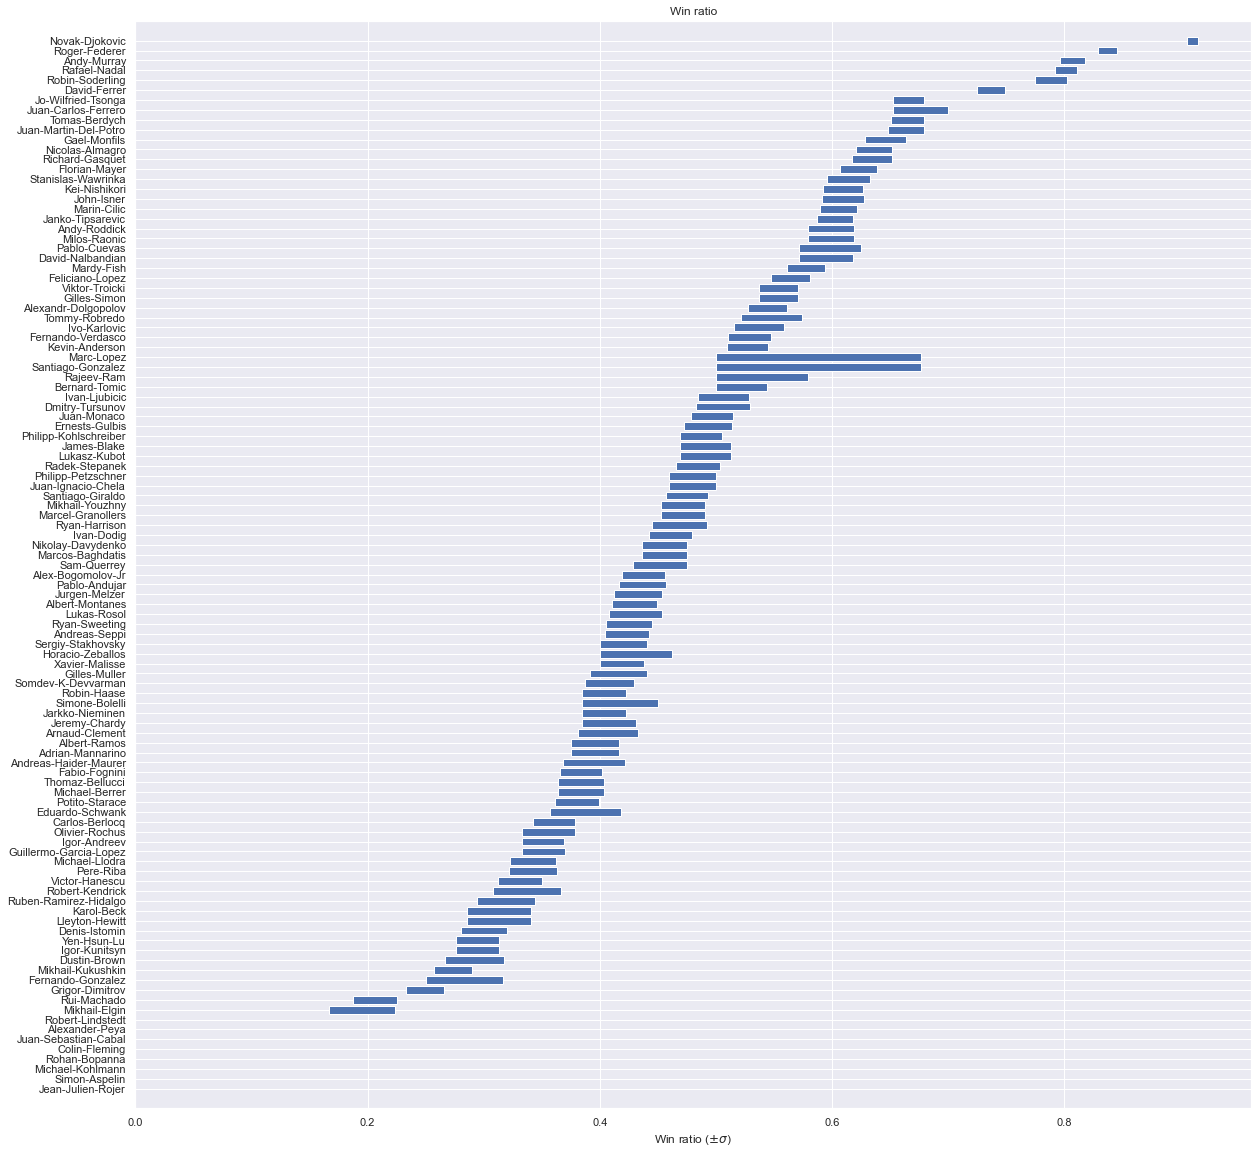

In [39]:
# empirical outcomes
points = np.zeros(M)
matches = np.zeros(M)

for p in range(0, M):
    for g in range(0, N):
        if G[g, 0] == p:
            points[p] += 1
            matches[p] += 1
        elif G[g, 1] == p:
            matches[p] += 1

win_ratio = np.true_divide(points, matches)
var = np.multiply(win_ratio, 1 - win_ratio)
win_std = np.true_divide(var, np.sqrt(matches))
sorted_rangeplot(
    win_ratio, win_std, W, label_x="Win ratio ($\pm \sigma$)", title_x="Win ratio"
)

<class 'str'>


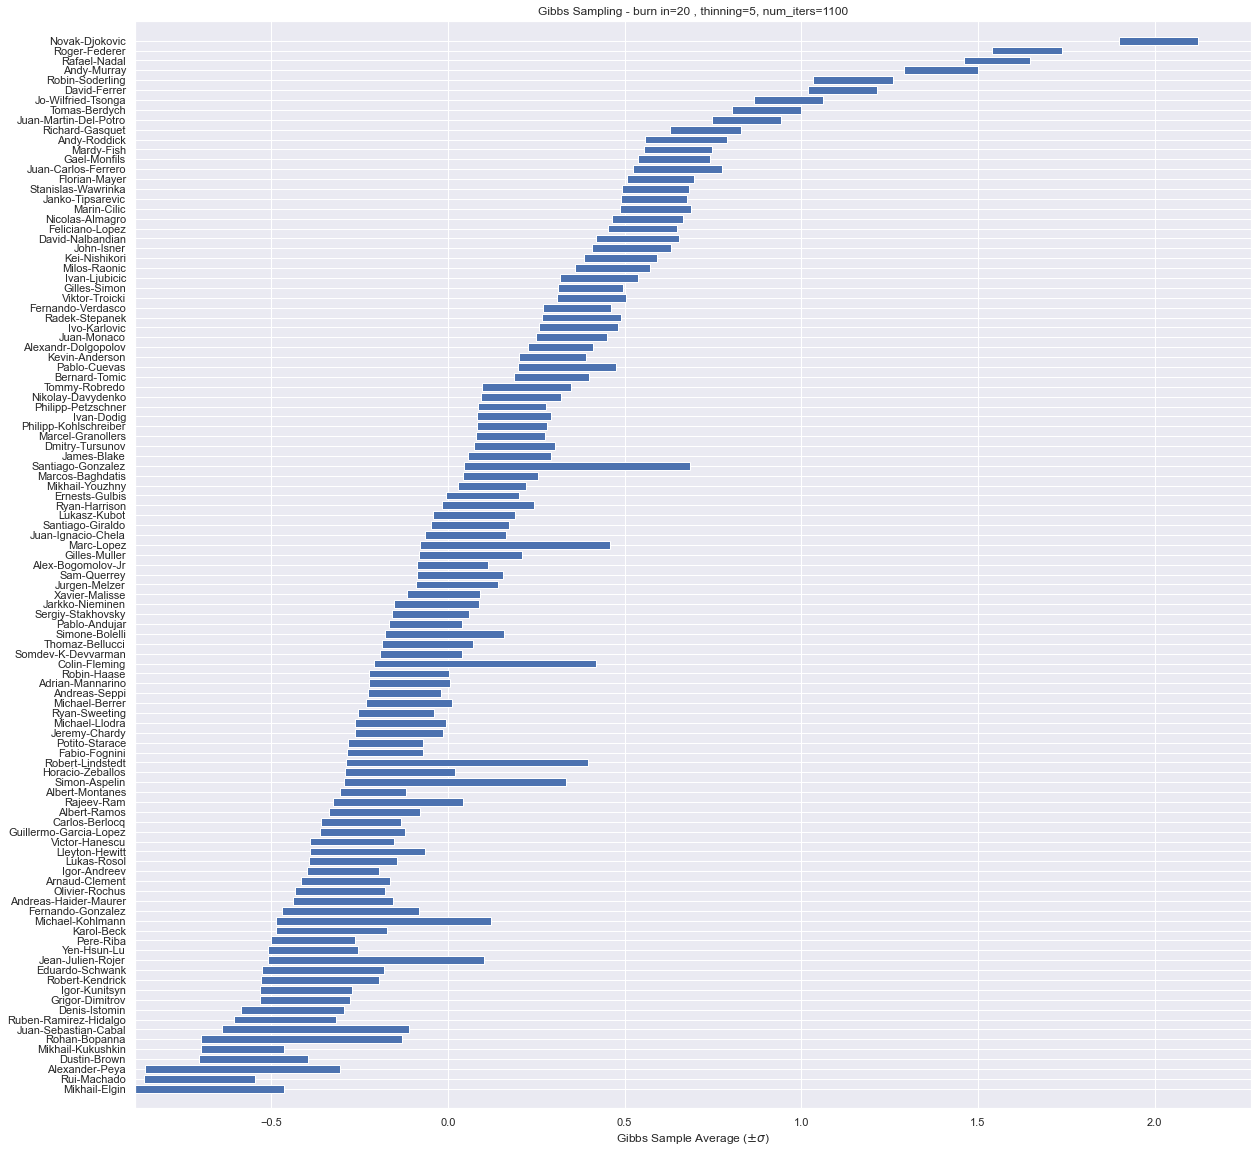

In [40]:
# predictions based on gibbs

burn_in = 20
thinning = 5
num_iters = 1100

indices = np.array(range(burn_in, num_iters, thinning))
relevant_samples = skill_samples[:, indices]

gibbs_means = np.mean(relevant_samples, axis=1)
gibbs_std = np.std(relevant_samples, axis=1)

sorted_rangeplot(
    gibbs_means,
    gibbs_std,
    W,
    label_x = "Gibbs Sample Average ($\pm \sigma$)",
    title_x = f"Gibbs Sampling - burn in={burn_in} , thinning={thinning}, num_iters={num_iters}"
)

<class 'str'>


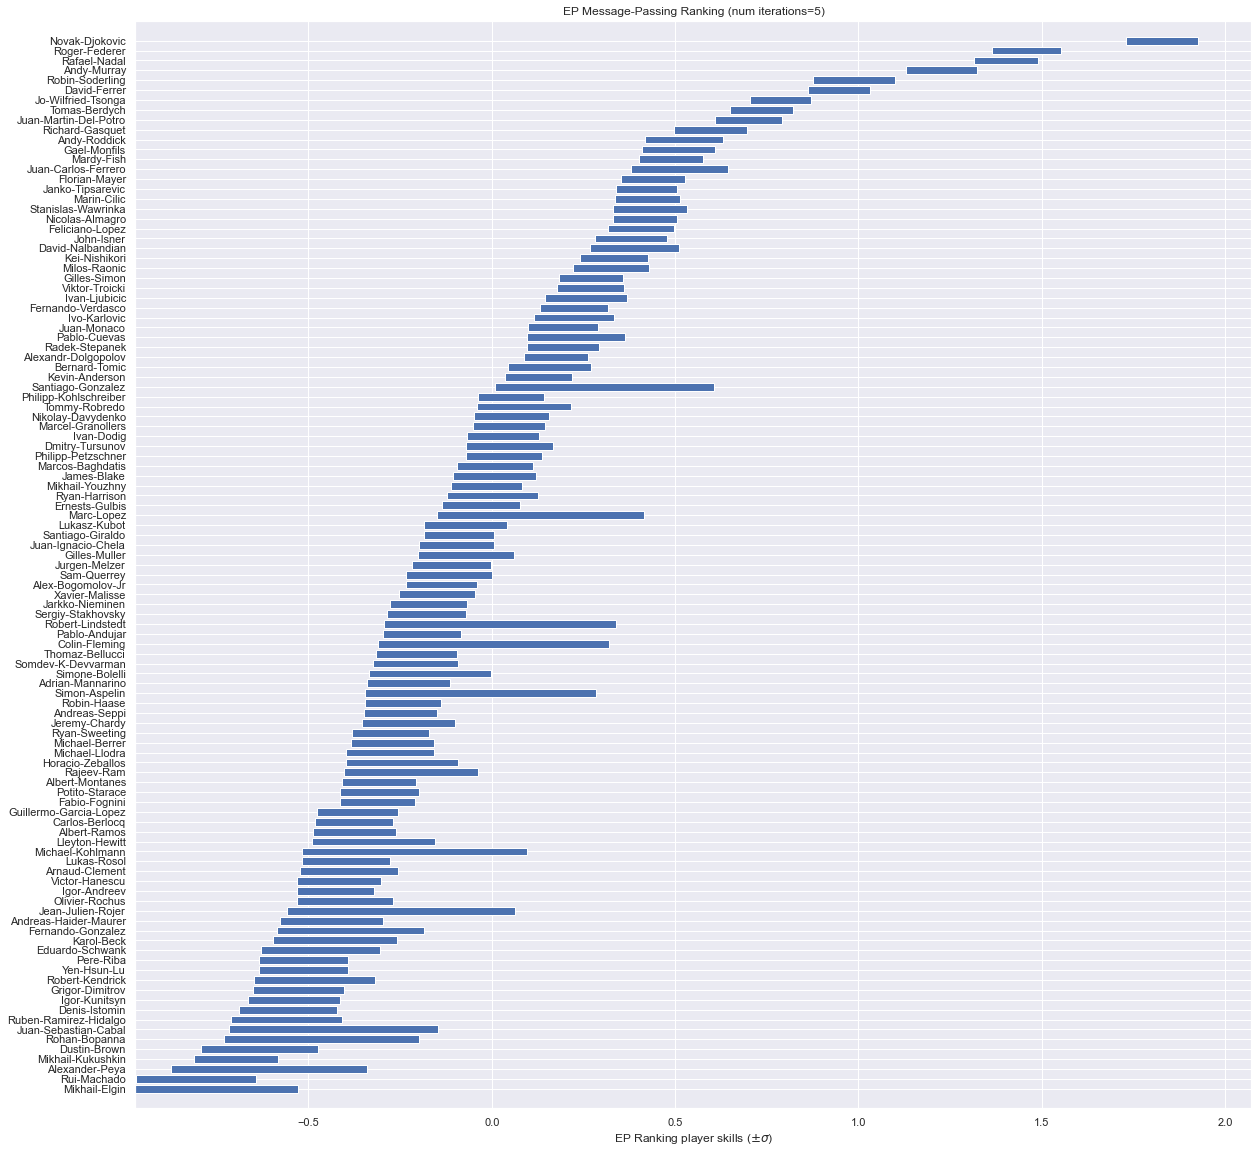

In [43]:
# Message Passing
num_iters = 5
# run message passing algorithm, returns mean and precision for each player
ep_means, precision_player_skills = eprank_non_iter(G, M, num_iters)

ep_std = np.sqrt(np.true_divide(1, precision_player_skills))
sorted_rangeplot(
    ep_means,
    ep_std,
    W,
    label_x="EP Ranking player skills ($\pm \sigma$)",
    title_x="EP Message-Passing Ranking (num iterations={})".format(num_iters),
)

In [44]:
from scipy.stats import spearmanr

win_rankings = np.argsort(win_ratio)
gibbs_rankings = np.argsort(gibbs_means)
ep_rankings = np.argsort(ep_means)

print(gibbs_rankings)
print(ep_rankings)

print(spearmanr(win_rankings, gibbs_rankings))
print(spearmanr(win_rankings, ep_rankings))
print(spearmanr(ep_rankings, gibbs_rankings))

[104  74  96  88  51 101  97  85  66  53  67  87  58 106  80  84  38 102
  82  91  36  93  77  94  70  55   6  50  72  95  90 103  56 105  43  73
  92  27  18  83  48  60  59  98  34  89  49  21  54  30  75  76  63  81
  13 100  78   9  86  71  39  52  26  99  65  61  45  68  17  64  40  69
  37  57  62  32   1  35  19  16  79  41  22   8  31  20  12  24  42  25
  47  46   7  44  28   3  14  11   2  33   5  29  23  10   0   4  15]
[104  74  96  51  88 101  97  85  66  67  53  87  80  84  58  38  82  91
 106  36  77  55  93  94 102  70  72  50   6  43  73  90  95  56  27  83
  18  92  48  59 103  60  49  34  89  98  21 105  54  30  75  81  63  76
  13  78   9  86 100  39  71  52  65  26  64  61  17  45  40  69  68  99
  62  37  32  19  57   1  35  16  22  79  41   8  31  12  20  24  42  46
  25  47   7  44   3  28  14  11   2  33   5  29  23  10   0   4  15]
SignificanceResult(statistic=0.5394992064891554, pvalue=2.0227872456334692e-09)
SignificanceResult(statistic=0.42723211661670485, 

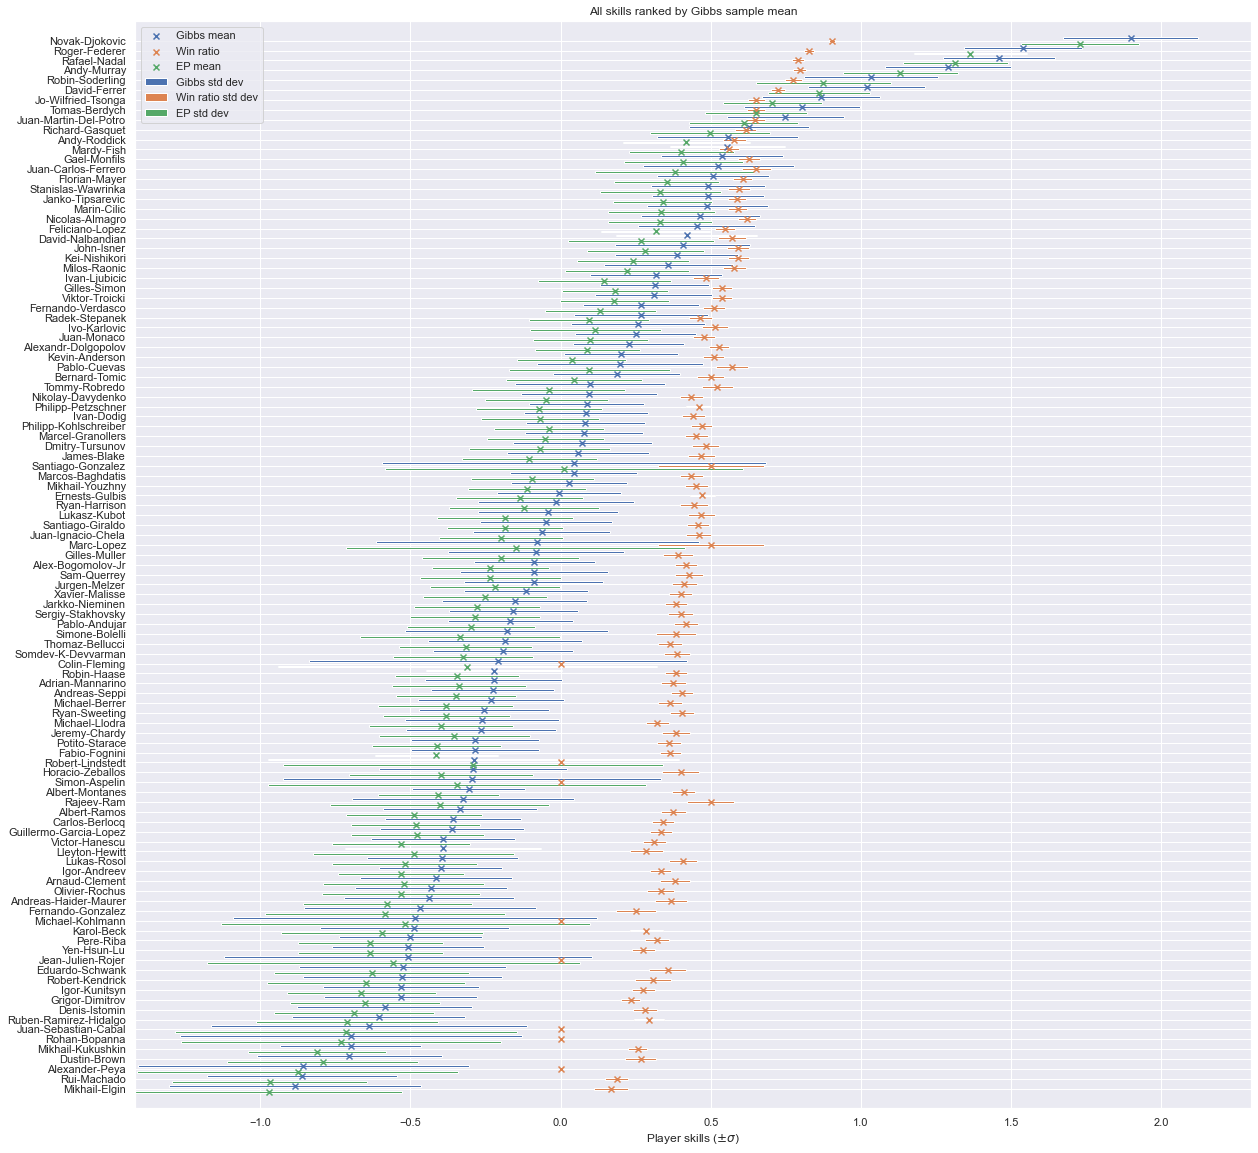

In [47]:
    mean = mean_player_skills
    std_dev = std_dev
    
    M = len(mean)
    xx = np.linspace(0, M, M)
    plt.figure(figsize=(20, 20))
    gibbs_rankings = np.argsort(gibbs_means)
    sorted_names = W[gibbs_rankings]
    
    plt.barh(xx+0.3, height=0.2, width=2*gibbs_std[gibbs_rankings], left=gibbs_means[gibbs_rankings] - gibbs_std[gibbs_rankings], label="Gibbs std dev")
    plt.barh(xx, height=0.2, width=2*win_std[gibbs_rankings], left=win_ratio[gibbs_rankings]-win_std[gibbs_rankings], label="Win ratio std dev")
    plt.barh(xx-0.3, height=0.2, width=2*ep_std[gibbs_rankings], left=ep_means[gibbs_rankings]-ep_std[gibbs_rankings], label="EP std dev")
    
    plt.scatter(gibbs_means[gibbs_rankings], xx+0.3, marker="x", color="C0", label="Gibbs mean")
    plt.scatter(win_ratio[gibbs_rankings], xx, marker="x", color="C1", label="Win ratio")
    plt.scatter(ep_means[gibbs_rankings], xx-0.3, marker="x", color="C2", label="EP mean")

    
    plt.yticks(xx, labels=sorted_names[:, 0])
    plt.ylim([-2, 109])
    plt.xlabel("Player skills ($\pm \sigma$)")
    plt.title("All skills ranked by Gibbs sample mean")
    plt.legend()
